# 2022 EY challenge - EcoCommons Notebook: using MaxEnt in R

---
**Author details:** EcoCommons Platform   
**Contact details:** comms@ecocommons.org.au  
**Date:** Frebruary 2022  
**Copyright statement:** This script is the product of EcoCommons platform.   
                      Please refer to the <a href="https://www.ecocommons.org.au/">EcoCommons website</a> for more details.

  
**Script and data info**:&nbsp;   
 In this notebook, you will run a Maximum Entropy Modeling (MaxeEnt) to predict 
 occurrences by finding the most uniform distribution within the limits of
 the predictor variables. Maxent is an open-source software created by Phillips and collaborators. More info can be found on <a href="https://biodiversityinformatics.amnh.org/open_source/maxent/">the MaxEnt website.</a>  
 Note that you will need to either install R and the required packages locally or run them in a remote/online environment to run the R code. Similarly, you will need to set your local machine to run Python and the required packages/libraries or run the code remotely. The EcoCommons platform is developing this functionality, but it is in the testing phase, so we encourage you to test out our platform. For now, work is best done locally or on more fully tested remote systems. For those of you new to R or Python, tips on how to get started <a href="https://datacarpentry.org/R-ecology-lesson/">can be found here</a> for R and <a href="https://datacarpentry.org/python-ecology-lesson/">can be found here</a> for Python.


*Please note that Java and MaxEnt must be installed on the running computer or server. We supply the netCDF file with the environmental variables you will need. Please refer to the "2022 EY Challenge - Weather Data" Python notebook provided by Dr. Brian Sullivan, CEOS Systems Engineering Office (SEO) at NASA Langley Research Center, if you want to download the data directly.*


**In this example you will:**
   1. Set up your environment  
   2. Download and clean your occurrence data 
   3. Import bioclimatic variables data from 'netCDF' files (code in Python - please refer to the "2022 EY Challenge - Weather Data" notebook)  
   4. Provide an example of MaxEnt run  
   5. List of other MaxEnt arguments you could run
    
   
------------------------------------------------------------------------

# 1. Set up your environment
---

The first step is to install all the necessary packages, so run the install.packages("xxx") line for any packages not already installed in the R environment you are using.

In [2]:
# if a package is installed, it will be loaded. If any not, the missing 
# package(s) will be installed from CRAN and then loaded

# supress warnings
options(warn= -1)

# first specify the packages of interest
packages <- c("dismo", "jpeg", "maps", "ncdf4", "raster", "rasterVis" , "readxl", 
              "rgbif", "rgeos", "rJava", "sp", "svMisc", "rgdal", "terra", "tidyr")
install.packages(packages)
lapply(packages, require, character.only = TRUE)


# now load or install&load all
package.check <- lapply(
  packages,
  FUN = function(x) {
    if (!require(x, character.only = TRUE)) {
      install.packages(x, dependencies = TRUE)
      library(x, character.only = TRUE)
    }
  }
)

search()

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



[[1]]
[1] TRUE

[[2]]
[1] TRUE

[[3]]
[1] TRUE

[[4]]
[1] TRUE

[[5]]
[1] TRUE

[[6]]
[1] TRUE

[[7]]
[1] TRUE

[[8]]
[1] TRUE

[[9]]
[1] TRUE

[[10]]
[1] TRUE

[[11]]
[1] TRUE

[[12]]
[1] TRUE

[[13]]
[1] TRUE

[[14]]
[1] TRUE

[1] ".GlobalEnv"        "package:tidyr"     "package:terra"    
 [4] "package:rgdal"     "package:svMisc"    "package:rJava"    
 [7] "package:rgeos"     "package:rgbif"     "package:readxl"   
[10] "package:rasterVis" "package:lattice"   "package:ncdf4"    
[13] "package:maps"      "package:dismo"     "package:raster"   
[16] "package:sp"        "jupyter:irkernel"  "package:stats"    
[19] "package:graphics"  "package:grDevices" "package:utils"    
[22] "package:datasets"  "package:methods"   "Autoloads"        
[25] "package:base"

In [7]:
# sets environment variables 
Sys.unsetenv('DISPLAY')

# if you want to delete previously saved '.RData' files
unlink(".RData")

Next, you will set up your working directory and create some folders within that working directory. Here we already have an 'EY_Feb_22' folder which will be used as our working directory. 

In [8]:
# check your current working directory
getwd()

# if you need to change the directory, use setwd("path/folder")
setwd("/home/jovyan/workspace/EY_frog_pseudoabsence/EY_Feb_2022")

[1] "/home/jovyan/workspace/EY_frog_pseudoabsence/EY_Feb_2022"

Here we can add some folders within the working directory, just to keep data organised.

In [9]:
raw_data_folder <- dir.create(paste0(getwd(),"/raw_data"))
data_folder     <- dir.create(paste0(getwd(),"/data"))
results_folder  <- dir.create(paste0(getwd(),"/results"))
scripts_folder  <- dir.create(paste0(getwd(),"/scripts"))

Check if MaxEnt is installed and if the three main files (maxent.bat, maxent.jar, and maxent.sh) are in your working directory. To check if MaxEnt is in the correct folder, you can run the following (*you may need to install Java first*).

In [10]:
jar <- paste(system.file(package = "dismo"), "/java/maxent.jar", sep = '') 
if (file.exists(jar)) {
  cat("can continue, MaxEnt is available")
  } else {
    cat('cannot run this because MaxEnt is not available')
}

can continue, MaxEnt is available

# 2. Download and filter / clean your species occurrence data
---
In this example, we download frog records (*Litoria fallax* - common name Eastern Dwarf Tree Frog)  from the GBIF database. As part of the challenge, we encourage participants to explore different species.

In [16]:
# select your species
my_species <- c("Litoria fallax")

# download GBIF occurrence data for this species; this takes time if there are many data points!
Litoria_fallax_GBIF_raw <- rgbif:: occ_data(scientificName = my_species,
                                            hasCoordinate  = TRUE,
                                            limit          = 45000)  # optional; set up a limit number of records

Get the information needed to cite this data.

In [18]:
# get the DOIs for citing these GBIF data 
citations <- rgbif::gbif_citation(Litoria_fallax_GBIF_raw)
head(citations)

[[1]]
<<rgbif citation>>
   Citation: iNaturalist contributors, iNaturalist (2022). iNaturalist
        Research-grade Observations. iNaturalist.org. Occurrence dataset
        https://doi.org/10.15468/ab3s5x accessed via GBIF.org on 2022-02-21..
        Accessed from R via rgbif (https://github.com/ropensci/rgbif) on
        2022-02-21
   Rights: http://creativecommons.org/licenses/by-nc/4.0/legalcode

[[2]]
<<rgbif citation>>
   Citation: NSW Department of planning, industry and environment (2022). NSW
        BioNet Atlas. Occurrence dataset https://doi.org/10.15468/14jd9g
        accessed via GBIF.org on 2022-02-21.. Accessed from R via rgbif
        (https://github.com/ropensci/rgbif) on 2022-02-21
   Rights: http://creativecommons.org/licenses/by/4.0/legalcode

[[3]]
<<rgbif citation>>
   Citation: Questagame (2021). Earth Guardians Weekly Feed. Occurrence dataset
        https://doi.org/10.15468/slqqt8 accessed via GBIF.org on 2022-02-21..
        Accessed from R via rgbif (http

Get familiar with the data, and check how the data is organized.

In [19]:
names(Litoria_fallax_GBIF_raw)
names(Litoria_fallax_GBIF_raw$meta)

[1] "meta" "data"

[1] "offset"       "limit"        "endOfRecords" "count"

In [20]:
# look at values used in the data
View(head(Litoria_fallax_GBIF_raw$data))

key,scientificName,decimalLatitude,decimalLongitude,issues,datasetKey,publishingOrgKey,installationKey,publishingCountry,protocol,⋯,taxonRemarks,disposition,previousIdentifications,higherClassification,georeferenceSources,georeferencedBy,associatedTaxa,verbatimTaxonRank,georeferenceRemarks,verbatimElevation
<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
3455478082,"Litoria fallax (Peters, 1880)",-25.33309,152.7615,cdround,50c9509d-22c7-4a22-a47d-8c48425ef4a7,28eb1a3f-1c15-4a95-931a-4af90ecb574d,997448a8-f762-11e1-a439-00145eb45e9a,US,DWC_ARCHIVE,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
3455529157,"Litoria fallax (Peters, 1880)",-26.71961,152.9579,cdround,50c9509d-22c7-4a22-a47d-8c48425ef4a7,28eb1a3f-1c15-4a95-931a-4af90ecb574d,997448a8-f762-11e1-a439-00145eb45e9a,US,DWC_ARCHIVE,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
3455635359,"Litoria fallax (Peters, 1880)",-27.05830,152.8228,cdround,50c9509d-22c7-4a22-a47d-8c48425ef4a7,28eb1a3f-1c15-4a95-931a-4af90ecb574d,997448a8-f762-11e1-a439-00145eb45e9a,US,DWC_ARCHIVE,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
3455760413,"Litoria fallax (Peters, 1880)",-25.33304,152.7615,cdround,50c9509d-22c7-4a22-a47d-8c48425ef4a7,28eb1a3f-1c15-4a95-931a-4af90ecb574d,997448a8-f762-11e1-a439-00145eb45e9a,US,DWC_ARCHIVE,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
3455774829,"Litoria fallax (Peters, 1880)",-25.75985,152.9591,cdround,50c9509d-22c7-4a22-a47d-8c48425ef4a7,28eb1a3f-1c15-4a95-931a-4af90ecb574d,997448a8-f762-11e1-a439-00145eb45e9a,US,DWC_ARCHIVE,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
3455901039,"Litoria fallax (Peters, 1880)",-27.17555,152.9918,cdround,50c9509d-22c7-4a22-a47d-8c48425ef4a7,28eb1a3f-1c15-4a95-931a-4af90ecb574d,997448a8-f762-11e1-a439-00145eb45e9a,US,DWC_ARCHIVE,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [21]:
# check unique values within datasets, and sort alphabetically

sort(unique(Litoria_fallax_GBIF_raw$data$datasetName))  # filter datasetName (FrogID)


[1] "1991-2001 Shoalwater Bay Army Training Reserve fauna surveys"
 [2] "1995 Northeastern NSW January and February"                  
 [3] "Bellinger Valley Community Sur"                              
 [4] "Boonooboonoo NP fauna survey"                                
 [5] "Central CRA Fauna Survey"                                    
 [6] "Clulow Frogs"                                                
 [7] "CRA Winter Survey 1998"                                      
 [8] "Cudgera Creek NR Fauna Survey"                               
 [9] "Data Priorities Fauna Survey"                                
[10] "Dave Stewart bird lists"                                     
[11] "Dharawal SCA & NR Fauna Survey"                              
[12] "DPIE Data from Scientific Licences dataset"                  
[13] "DPIE Default Analyses"                                       
[14] "DPIE Default Sightings"                                      
[15] "Fauna of Lower Hunter NP"                                    
[16] "FrogID"                                                      
[17] "Garry Daly Survey"                                           
[18] "GC-offsets Fauna Survey"                                     
[19] "Georges River Biodiversity Sur"                              
[20] "Gosford City Fauna Survey"                                   
[21] "Goulburn River NP Survey"                                    
[22] "Greater Sydney ETS Surveys"                                  
[23] "Hunter Wetlands Fauna"                                       
[24] "Illawarra ETS Surveys"                                       
[25] "Illawarra Fauna Survey"                                      
[26] "Iluka Community Survey"                                      
[27] "iNaturalist research-grade observations"                     
[28] "Individual sighting"                                         
[29] "Jervis Bay Fauna Survey"                                     
[30] "Joint Old Growth Project"                                    
[31] "LNE Summer Survey 1997/98"                                   
[32] "Lower Hawesbury Fauna Surveys"                               
[33] "Lower North East CRA Survey"                                 
[34] "Maroota Ridge SCA Fauna Survey"                              
[35] "Mater dei - Camden Fauna Survey"                             
[36] "Michelle Stockwell frogs"                                    
[37] "MJD Environmental Surveys"                                   
[38] "Myall Coast Koala Project"                                   
[39] "Nandewar Bio-region Assessment"                              
[40] "NMNH Extant Biology"                                         
[41] "North Coast Region Fauna Surve"                              
[42] "NRAC Upper North East Fauna"                                 
[43] "Nymboi-Binderay NP Survey"                                   
[44] "NZCRA Collated data"                                         
[45] "OEH Data from Scientific Licences dataset"                   
[46] "OEH Default Sightings"                                       
[47] "Palm Grove NR Fauna Surveys"                                 
[48] "Royal Biodiversity Survey"                                   
[49] "SCA Special Area Fauna Survey"                               
[50] "SCR NPWS General Fauna Surveys"                              
[51] "State Forests Biodata"                                       
[52] "Stewart, D. CD Collection"                                   
[53] "Stewart, D. Sound Devices Collection 2006-2010"              
[54] "Sydney Metro CMA Rapid Fauna"                                
[55] "Sydney Region Fauna Surveys"                                 
[56] "Upper North East CRA Survey"                                 
[57] "Urban Bushland Biodiversity 2"                               
[58] "Western Sydney Fauna Surveys"                                
[59] "Wildlife Rehab Database"                           

Get the columns that matter for mapping and cleaning the occurrence data. Here is an example of columns that you can select.

In [22]:
litoria_fallax <- Litoria_fallax_GBIF_raw$data [ , c("decimalLongitude", "decimalLatitude",
                                                     "individualCount", "species", "year",
                                                     "month", "country", "occurrenceStatus",
                                                     "coordinateUncertaintyInMeters", "datasetName",
                                                     "datasetKey")]
View(head(litoria_fallax))

decimalLongitude,decimalLatitude,individualCount,species,year,month,country,occurrenceStatus,coordinateUncertaintyInMeters,datasetName,datasetKey
<dbl>,<dbl>,<int>,<chr>,<int>,<int>,<chr>,<chr>,<dbl>,<chr>,<chr>
152.7615,-25.33309,NA,Litoria fallax,2022,1,Australia,PRESENT,10,iNaturalist research-grade observations,50c9509d-22c7-4a22-a47d-8c48425ef4a7
152.9579,-26.71961,NA,Litoria fallax,2022,1,Australia,PRESENT,4253,iNaturalist research-grade observations,50c9509d-22c7-4a22-a47d-8c48425ef4a7
152.8228,-27.05830,NA,Litoria fallax,2022,1,Australia,PRESENT,3,iNaturalist research-grade observations,50c9509d-22c7-4a22-a47d-8c48425ef4a7
152.7615,-25.33304,NA,Litoria fallax,2022,1,Australia,PRESENT,10,iNaturalist research-grade observations,50c9509d-22c7-4a22-a47d-8c48425ef4a7
152.9591,-25.75985,NA,Litoria fallax,2022,1,Australia,PRESENT,8,iNaturalist research-grade observations,50c9509d-22c7-4a22-a47d-8c48425ef4a7
152.9918,-27.17555,NA,Litoria fallax,2022,1,Australia,PRESENT,31,iNaturalist research-grade observations,50c9509d-22c7-4a22-a47d-8c48425ef4a7


Write a copy of the raw data with selected columns to a folder where you can store a clean version.

### Filter your species occurrence data


To facilitate the data manipulation, we recommend transforming it into a 'tibble', an S3 generic with more efficient matrices and data frames methods. Then, add the necessary filters and save the filtered data in a 'csv' format. Here are some examples.

In [23]:
lfallax_tibble <- tibble::as_tibble(litoria_fallax)
length(lfallax_tibble$datasetName)  # number of records

lfallax_FrogID  <- lfallax_tibble[lfallax_tibble$datasetName == "FrogID",]  # filter data only from FrogID
lfallax_FrogID2 <- lfallax_FrogID[lfallax_FrogID$coordinateUncertaintyInMeters < 200,]  # only include precice coordinates
lfallax_FrogID3 <- lfallax_FrogID2[!is.na(lfallax_FrogID2$datasetName),]  # remove NAs

length(lfallax_FrogID3$datasetName)  #  number of records - notice the large drop after filtering


[1] 45000

[1] 22371

In [24]:
getwd()
write.csv(lfallax_FrogID3,paste0(getwd(),"/data/Litoria_fallax_FrogID_17Feb2022.csv"))

[1] "/home/jovyan/workspace/EY_frog_pseudoabsence/EY_Feb_2022"

### Map the occurrence data  
When downloading data from big datasets, some records are likely to be centroids of(relatively large) grid cells on which particular surveys were based. You can notice them when distribution records are too regularly spaced to be exact locations of species sightings. When it happens, remember to adjust the spatial resolution of your analysis accordingly.

We will be using data from the 'FrogID'  dataset. FrogID is an Australian citizen science project that records frog calls with a unique, time-stamped, and geo-referenced audio recording. Centroid location is not an issue in the case.

Please cite the 'frogID'  if using their records: 
Rowley JJL, & Callaghan CT (2020) The FrogID dataset: expert-validated occurrence records of Australia’s frogs collected by citizen scientists. ZooKeys 912: 139-151

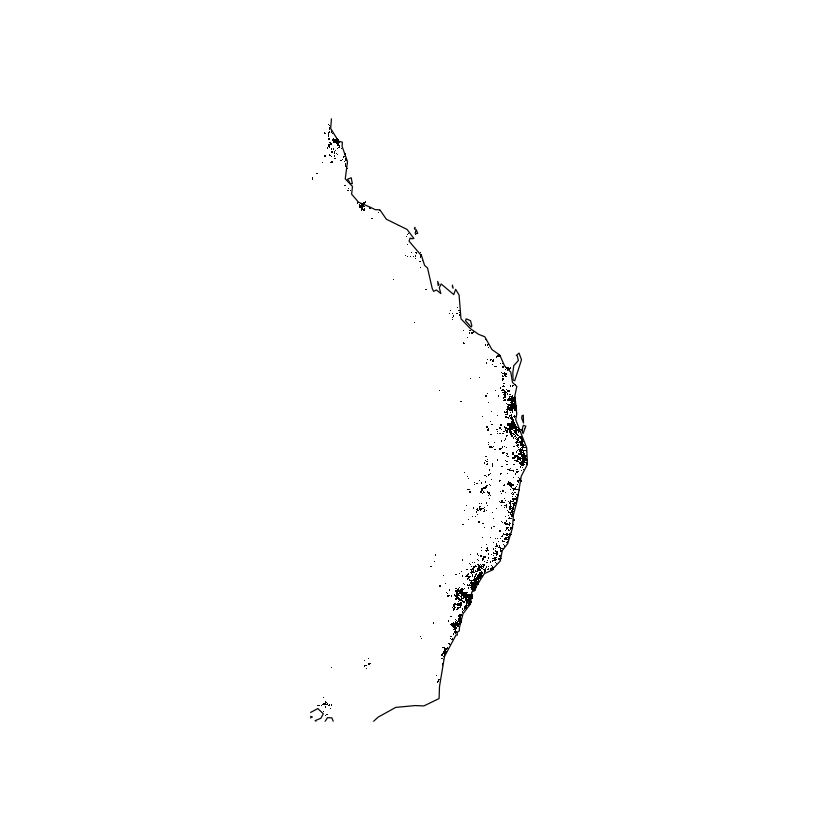

In [25]:
# if the map doesn't appear right at first, run this command again
map("world", xlim = range(lfallax_FrogID3$decimalLongitude),
    ylim = range(lfallax_FrogID3$decimalLatitude))  
points(lfallax_FrogID3[ , c("decimalLongitude", "decimalLatitude")], pch = ".")


# 3. Load and process the bioclimatic data
---
As part of the challenge, you are encouraged to explore multiple regions around Australia's east to get a representative subsample of the training data for the one species of concern.

It is example, we will be using data from a netCDF file, obtained from "TerraClimate", a dataset of monthly climate and climatic water balance for global terrestrial surfaces from 1958-2019. Please refer to the "2022 EY Challenge - Weather Data" notebook to get the data, which needs to be set up and run separately in a python environment. Be sure to save the final data in a format that R can read. Then, use the code below to load the data into R.  Here, we decided to include four climatic variables (maximum and minimum temperature, rainfall and soil cover - called "tmax", "tmin", "ppt" and "soil", respectively), covering the Greater Sydney, NSW, Australia.

In [30]:
# read NetCDF data file obtained from "TerraClimate"
file <- "raw_data/Terraclim_EY_NSW.nc"

var_names <- c("tmax", "tmin", "ppt", "soil")  

# save a netcdf file of each of your variable in your directory folder
for (var_name in var_names) {
  
  # Create raster stack
  var_brick <- raster::brick(file, varname = var_name)
  var_mean  <- mean(var_brick)
  plot(var_mean)  # visualise each variable  
  dev.off()
  
  #create netcdf file
  raster::writeRaster(x         = var_mean, 
                      filename  = paste0("data/",var_name),
                      overwrite = TRUE, 
                      format    = 'CDF')
  }

ERROR: Error in .varName(nc, varname, warn = warn): varname: tmax does not exist in the file. Select one from:
layer


Create a spatial points layer with the species distribution points.

In [50]:
x_lfallax <- lfallax_FrogID3$decimalLongitude
y_lfallax <- lfallax_FrogID3$decimalLatitude
xy_lfallax <- cbind(x_lfallax, y_lfallax)
colnames(xy_lfallax) <- c("x", "y")
xy_sp_lfallax <- sp::SpatialPoints(coords = xy_lfallax)  # create a spatial points layer

# project - choose a coordinate reference system
crs(xy_sp_lfallax) <- "+proj=longlat +datum=WGS84 +no_defs" 

Remove distribution records that are outside of your area of interest and plot to see the result.

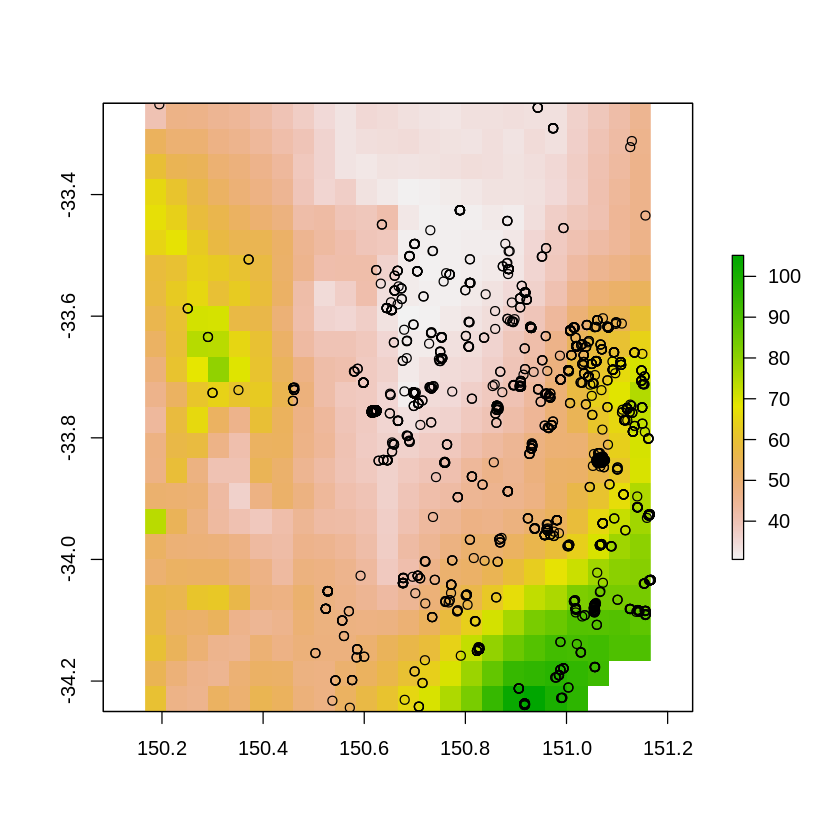

In [51]:
xy_lfallax <- raster::crop(xy_sp_lfallax, var_mean)

plot(var_mean)
points(xy_lfallax)

Stack the predictors together and rename them. Plot to see the result.

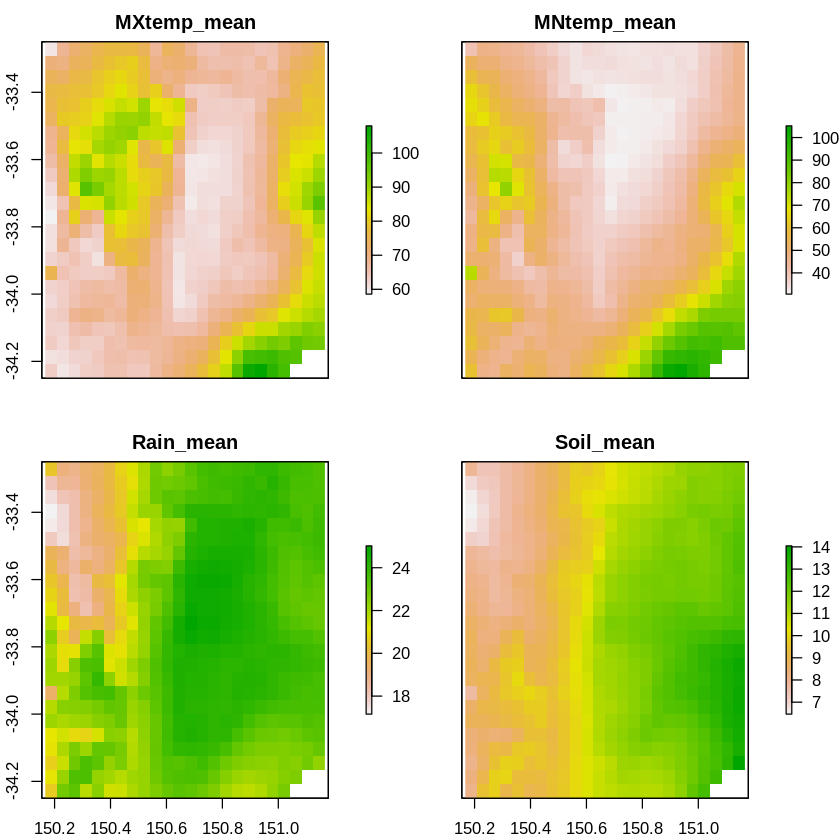

In [27]:
setwd("/home/jovyan/workspace/EY_frog_pseudoabsence/EY_Feb_2022/data")
fls <- list.files(pattern = '.nc$', all.files= TRUE)
fls2 <- paste0(getwd(), "/", fls)
predictors <- raster::stack(fls)
names(predictors) <- c('Rain_mean', 'Soil_mean', 'MXtemp_mean', 'MNtemp_mean')
plot(predictors)

In [52]:
# check your current working directory
getwd()

# if you need to change the directory, use setwd("path/folder")
setwd("/home/jovyan/workspace/EY_frog_pseudoabsence/EY_Feb_2022")

[1] "/home/jovyan/workspace/EY_frog_pseudoabsence/EY_Feb_2022/data"

In [28]:
predictors

class      : RasterStack 
dimensions : 24, 24, 576, 4  (nrow, ncol, ncell, nlayers)
resolution : 0.04166667, 0.04166667  (x, y)
extent     : 150.1667, 151.1667, -34.25, -33.25  (xmin, xmax, ymin, ymax)
crs        : +proj=longlat +datum=WGS84 +no_defs 
names      : MXtemp_mean, MNtemp_mean, Rain_mean, Soil_mean 
min values :   58.600000,   30.616667, 17.160002,  6.461668 
max values :     107.950,     105.150,    25.020,    14.045 


# OPTIONAL: This step is one you would never actually do

Here we are making these environmental rasters higher resolution simply so there are enough raster cells to run a maxent model.

These data are already spatially autocorrelated, and this step increases that problem, but it allows us to present an example with these data.

In [29]:
res(predictors)

[1] 0.04166667 0.04166667

In [30]:
predictors2 <- raster::disaggregate(predictors, fact = 30)
res(predictors2)

[1] 0.001388889 0.001388889

In [31]:
predictors2

class      : RasterBrick 
dimensions : 720, 720, 518400, 4  (nrow, ncol, ncell, nlayers)
resolution : 0.001388889, 0.001388889  (x, y)
extent     : 150.1667, 151.1667, -34.25, -33.25  (xmin, xmax, ymin, ymax)
crs        : +proj=longlat +datum=WGS84 +no_defs 
source     : memory
names      : MXtemp_mean, MNtemp_mean, Rain_mean, Soil_mean 
min values :   58.599998,   30.616667, 17.160002,  6.461668 
max values :     107.950,     105.150,    25.020,    14.045 


In [60]:
mask_r <- predictors2[[2]]
ext <- raster::extent(predictors2)

# 4. Provide an example of MaxEnt run
---

### Prepare data and fit model

First, create training and test points.

In [56]:
group <- dismo::kfold(xy_lfallax, k = 5)
pres_test  <- xy_lfallax[group == 1, ]  # 20% of data sample for testing
pres_train <- xy_lfallax[group != 1, ]

Set the background points and check NAs.

In [95]:
backg <- dismo::randomPoints(mask = mask_r, n = 1000)
colnames(backg) <- c("lon", "lat")

# check the number of NAs
x <- raster::extract(predictors2, pres_train) 
y <- na.omit(x)
na_count <- length(y)/length(x)  # need to be 0.5 or more
na_count 


[1] 1

### Set the various Maxent arguments

A full list of the available arguments are at the end of the notebook.  Other things to consider, are adding a bias layer.

In [75]:
maxent_args <- c('removeduplicates= TRUE','jackknife= TRUE')

### Run the model

There are different ways to run MaxEnt in R. We choose to use the 'dismo' package.

In [76]:
basic_maxent<- dismo::maxent(predictors2,
                             pres_train,
                             path = "results",
                             args = maxent_args)

This is MaxEnt version 3.4.3 


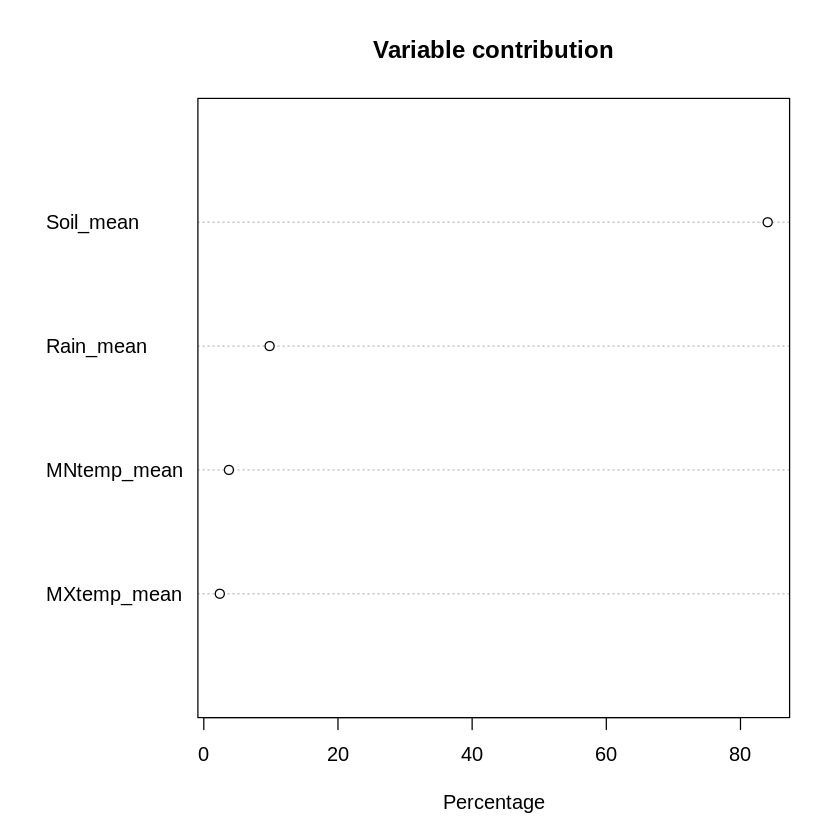

In [77]:
plot(basic_maxent)

Create a RasterLayer with the prediction.

In [78]:
map_predictions <- dismo::predict(basic_maxent, predictors2)

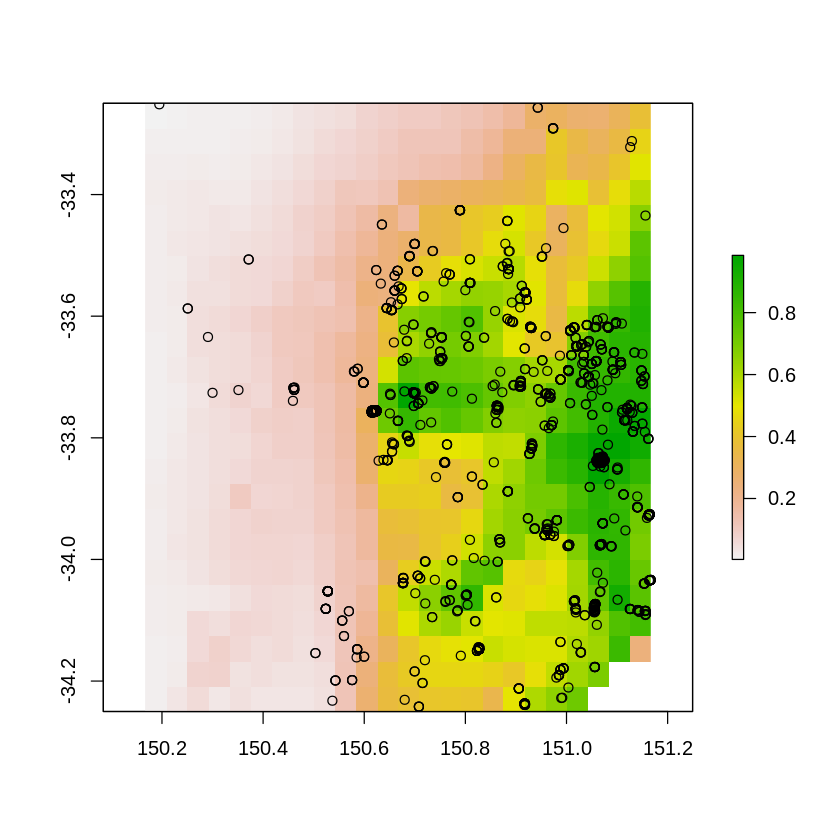

In [79]:
plot(map_predictions)
points(pres_train)

Use the 'evaluate' function on 'dismo' package to see some key results.

In [82]:
evaluate_model <- dismo::evaluate(pres_train, pres_test, basic_maxent, predictors2)
evaluate_model

class          : ModelEvaluation 
n presences    : 460 
n absences     : 1000 
AUC            : 0.7614924 
cor            : 0.4217252 
max TPR+TNR at : 0.2733821 

In [81]:
evaluate_model@auc

[1] 0.7614924

In [29]:
# save the results in 'jpeg'

jpeg(paste0(getwd(),"/results/Litoria_fallax_predicted.jpeg"))
plot(map_predictions)
points(pres_train)
dev.off()


ERROR: Error in h(simpleError(msg, call)): error in evaluating the argument 'x' in selecting a method for function 'plot': object 'map_predictions' not found


In [ ]:
#save the results in an 'asc' file

raster::writeRaster(map_predictions,
                    filename  = "results/Litoria_fallax_pred.asc",
                    format    = "ascii",
                    overwrite = TRUE)

Find a threshold (cut-off) to transform model predictions probabilities to a binary score (presence or absence).

In [85]:
threshold_model <- dismo::threshold(evaluate_model, 'spec_sens')
threshold_model

[1] 0.2733821

Now, it is time to reclasify the values of the raster object. This is step is OPTIONAL.

In [86]:
m <- c(0, 0.32888036, 0,  0.32888036, 1, 1)
reclass <- matrix(m, ncol = 3, byrow = TRUE)
rc <- raster::reclassify(map_predictions, reclass)

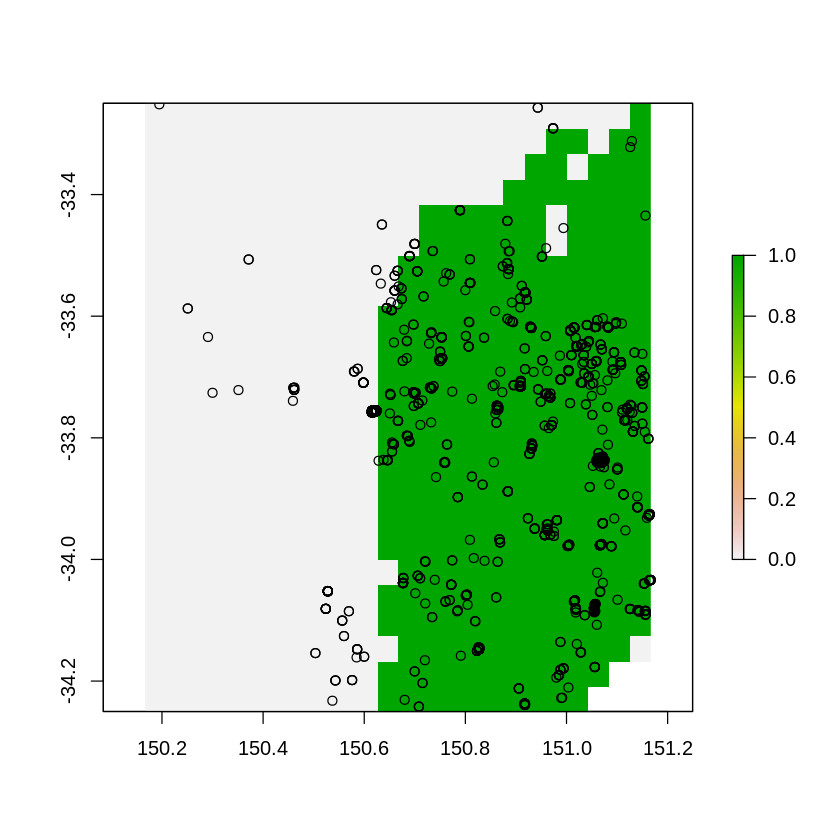

In [87]:
plot(rc)
points(pres_train)
jpeg(paste0(getwd(), "/results/EDTF_pres_absence_map.jpeg")) # save the image

In [88]:
# now, plot the presence/absence

plot(rc, main = 'presence/absence')
points(pres_train, pch = '+')
dev.off()

png 
  2

Generate response plots, single variable response curves for the model you run.

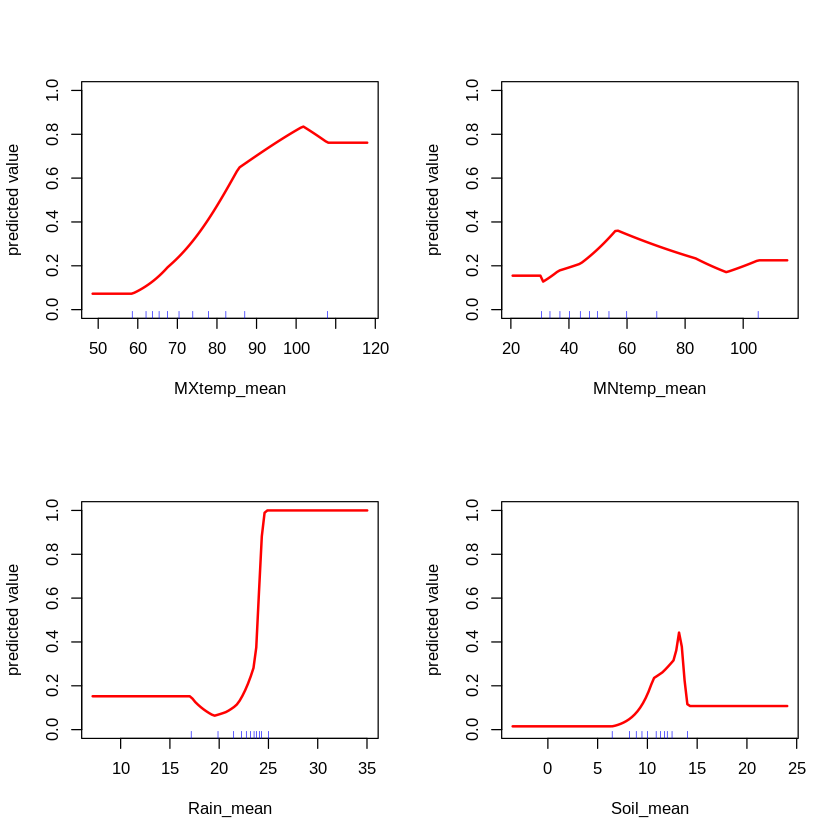

In [89]:
dismo::response(basic_maxent)

Creaate a data frame with the evaluation results.

In [92]:
myspecies <- c("Litoria fallax")
cor <- unname(evaluate_model@cor)
test_data_results <- as.data.frame(list(myspecies,
                                        evaluate_model@np,
                                        evaluate_model@na,
                                        evaluate_model@auc,
                                        cor))

In [93]:
colnames(test_data_results) <- c("species", "presences", "absences", "AUC", "cor")
test_data_results

species,presences,absences,AUC,cor
<chr>,<int>,<int>,<dbl>,<dbl>
Litoria fallax,460,1000,0.7614924,0.4217252


Another option to visualize the results.

In [94]:
basic_maxent@results

X.Training.samples,511.0000
Regularized.training.gain,0.6275
Unregularized.training.gain,0.7010
Iterations,500.0000
Training.AUC,0.8114
X.Background.points,10000.0000
MNtemp_mean.contribution,3.7453
MXtemp_mean.contribution,2.3877
Rain_mean.contribution,9.8121
Soil_mean.contribution,84.0549
MNtemp_mean.permutation.importance,8.1496


# 5. List of other MaxEnt arguments you could run

In [ ]:
maxent_args <- c(
  
  #duplicate records
  'removeduplicates=TRUE', #remove duplicate presence records. If environmental data are in grids, duplicates are records in the same grid cell, otherwise, duplicates are records with identical coordinates.
  
  #background records
  'maximumbackground=10000', #if the number of background points/grid cells is larger than this number, then this number of cells is chosen randomly for background points.
  'addsamplestobackground=TRUE', #add to the background any sample for which has a combination of environmental values that isn't already present in the background
  'addallsamplestobackground=FALSE', #add all samples to the background, even if they have combinations of environmental values that are already present in the background
  
  #missing data
  'allowpartialdata=FALSE', #during model training, allow use of samples that have nodata values for one or more environmental variables
  
  #variable importance
  'jackknife=TRUE', #NB: default=FALSE; measure importance of each environmental variable by training with each environmental variable first omitted, then used in isolation.
  
  #random seed
  'randomseed=FALSE', #if selected, a different random seed will be used for each run, so a different random test/train partition will be made and a different random subset of the background will be used, if applicable.
  
  #prevalence
  'defaultprevalence=0.5', #default prevalence of the species: probability of presence at ordinary occurrence points. See Elith et al. Diversity and Distributions, 2011 for details
  
  #train/test settings
  'randomtestpoints=0', #percentage of presence localities to be randomly set aside as test points, used to compute AUC, omission, etc.
  'replicates=1', #number of replicate runs to do when cross-validating, bootstrapping or doing sampling with replacement runs.
  'replicatetype=crossvalidate', #if replicates > 1, do multiple runs of this type: 
      #crossvalidate: samples divided into replicates fods; each fold in turn used for test data
      #bootstrap: replicate sample sets chosen by sampling with replacement
      #subsample: replicate sample sets chosen by removing random test percentage without replacement to be used for evaluation
  'maximumiterations=500', #stop training after this many iterations of the optimization algorithm
  'convergencethreshold=0.00001', #stop training when the drop in log loss per iteration drops below this number 
  
  #feature selection
  'autofeature=TRUE', #automatically select which feature classes to use, based on number of training samples
  'linear=TRUE', #allow linear features to be used
  'quadratic=TRUE', #allow quadratic features to be used
  'product=TRUE', #allow product features to be used
  'threshold=TRUE', #allow threshold features to be used
  'hinge=TRUE', #allow hinge features to be used
  
  #feature settings
  'lq2lqptthreshold=80', #number of samples at which product and threshold features start being used
  'l2lqthreshold=10', #number of samples at which quadratic features start being used
  'hingethreshold=15', #number of samples at which hinge features start being used
  
  #regularization settings
  'betamultiplier=1', #multiply all automatic regularization parameters by this number. A higher number gives a more spread-out distribution.
  'beta_threshold=-1', #regularization parameter to be applied to all threshold features; negative value enables automatic setting
  'beta_categorical=-1', #regularization parameter to be applied to all categorical features; negative value enables automatic setting
  'beta_lqp=-1', #regularization parameter to be applied to all linear, quadratic and product features; negative value enables automatic setting
  'beta_hinge=-1', #regularization parameter to be applied to all hinge features; negative value enables automatic setting
  
  #outputs - NB. These are not shown in the UI, so unable to be changed by user
  
  'responsecurves=TRUE', #NB. default=FALSE; create graphs showing how predicted relative probability of occurrence depends on the value of each environmental variable
  'responsecurvesexponent=FALSE', #instead of showing the logistic value for the y axis in response curves, show the exponent (a linear combination of features).
  'pictures=TRUE', #create a .png image for each output grid
  'outputformat=raw', #representation of probabilities used in writing output grids, see Help for details
  'writeclampgrid=TRUE', #write a grid that shows the spatial distribution of clamping. At each point, the value is the absolute difference between prediction values with and without clamping.
  'writemess=TRUE', #a multidimensional environmental similarity surface (MESS) shows where novel climate conditions exist in the projection layers. The analysis shows both the degree of novelness and the variable that is most out of range at each point.
  'writeplotdata=FALSE', #write output files containing the data used to make response curves, for import into external plotting software.
  'outputgrids=TRUE', #write output grids. Turning this off when doing replicate runs causes only the summary grids (average, std, deviation, etc) to be written, not those for the individual runs.
  'plots=TRUE', #write various plots for inclusion in .html output
  'logfile=maxent.log', #file name to be used for writing debugging information about a run in output directory
  #'applythresholdrule=Fixed cumulative value 1', #apply a threshold rule, generating a binary outputgrid in addition to the regular prediction grid. Use the full name of the threshold rule in Maxent's html output as the argument. For example 'applyThresholdRule=Fixed cumulative value 1'.
  'logscale=TRUE', #if selected, all pictures of models will use a logarithmic scale for color-coding
  'writebackgroundpredictions=FALSE', #write .csv file with predictions at background points
  'fadebyclamping=FALSE', #reduce prediction at each point in projections by the difference between clamped and non-clamped output at that point

  #projection settings NB. These are not shown in the UI, so unable to be changed by user
  
  'extrapolate=TRUE', #predict to regions of environmental space outside the limits encountered during training
  'doclamp=TRUE' #apply clamping when projecting
  
)